In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [289]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [290]:
data = pd.read_csv('../data/num_file/hrs_01/p040.csv')

In [291]:
print(data)

                 datetime  count
0     2022-04-21 01:00:00   1033
1     2022-04-21 02:00:00     65
2     2022-04-21 03:00:00      0
3     2022-04-21 04:00:00      0
4     2022-04-21 05:00:00      0
...                   ...    ...
3246  2022-09-03 07:00:00   9741
3247  2022-09-03 08:00:00  19613
3248  2022-09-03 09:00:00  22055
3249  2022-09-03 10:00:00  14644
3250  2022-09-03 11:00:00  12751

[3251 rows x 2 columns]


If there is no people, use NaN.

In [292]:
data.loc[data['count']==0, 'count'] = np.NaN

In [293]:
print(data)

                 datetime    count
0     2022-04-21 01:00:00   1033.0
1     2022-04-21 02:00:00     65.0
2     2022-04-21 03:00:00      NaN
3     2022-04-21 04:00:00      NaN
4     2022-04-21 05:00:00      NaN
...                   ...      ...
3246  2022-09-03 07:00:00   9741.0
3247  2022-09-03 08:00:00  19613.0
3248  2022-09-03 09:00:00  22055.0
3249  2022-09-03 10:00:00  14644.0
3250  2022-09-03 11:00:00  12751.0

[3251 rows x 2 columns]


<Axes: >

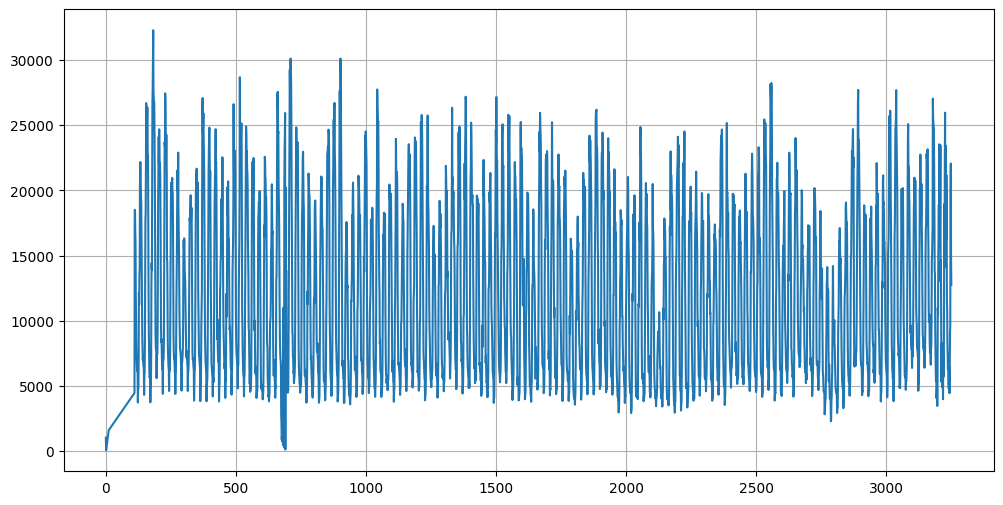

In [294]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

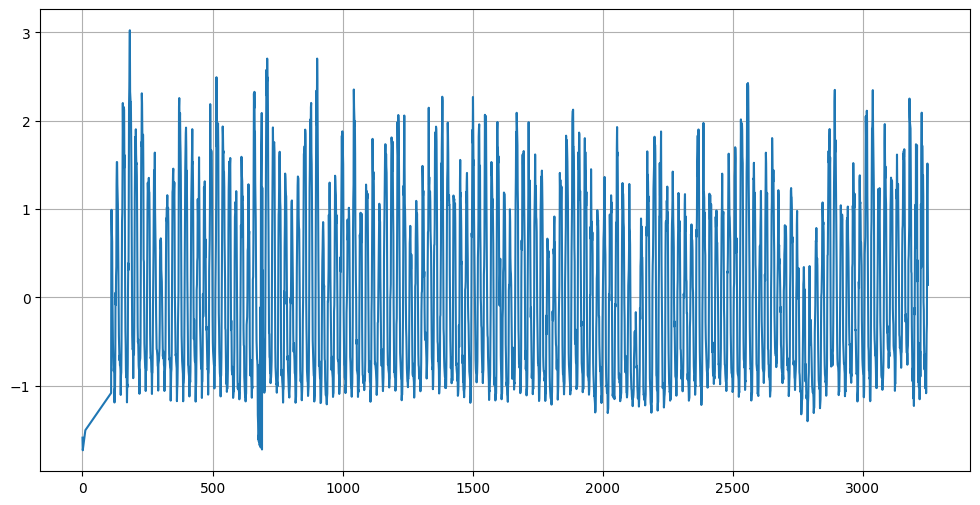

In [295]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [296]:
print(data)

                 datetime     count
0     2022-04-21 01:00:00 -1.588140
1     2022-04-21 02:00:00 -1.730996
2     2022-04-21 03:00:00 -1.708284
3     2022-04-21 04:00:00 -1.685572
4     2022-04-21 05:00:00 -1.662859
...                   ...       ...
3246  2022-09-03 07:00:00 -0.303021
3247  2022-09-03 08:00:00  1.153879
3248  2022-09-03 09:00:00  1.514267
3249  2022-09-03 10:00:00  0.420559
3250  2022-09-03 11:00:00  0.141192

[3251 rows x 2 columns]


In [297]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 6

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [298]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [299]:
train_size = int(len(encode_input_data)*0.7)
validate_size = int(len(encode_input_data)*0.25)
test_size = len(encode_input_data) - train_size - validate_size
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_validate = encode_input_data[train_size:train_size+validate_size]
decode_input_data_validate = decode_input_data[train_size:train_size+validate_size]
decode_output_data_validate = decode_output_data[train_size:train_size+validate_size]
encode_input_data_test = encode_input_data[train_size+validate_size:]
decode_input_data_test = decode_input_data[train_size+validate_size:]
decode_output_data_test = decode_output_data[train_size+validate_size:]

In [300]:
print(decode_output_data[:, -1, :])

[[-1.61743441]
 [-1.59472199]
 [-1.57200957]
 ...
 [ 1.15387905]
 [ 1.51426713]
 [ 0.42055868]]


## Model

In [301]:
from keras.layers import Input, LSTM, BatchNormalization, TimeDistributed, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [302]:
input_data = Input(shape=(time_step, 1))
x = LSTM(32, return_sequences=True)(input_data)
x = BatchNormalization()(x)
output_data = TimeDistributed(Dense(1))(x)

In [303]:
model = Model(inputs=input_data, outputs=output_data)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 6, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 6, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 6, 1)           │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,449 (17.38 KB)

 Non-trainable params: 64 (256.00 B)

In [304]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_data=(encode_input_data_validate, decode_output_data_validate)) #callbacks=[es])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.4087 - mae: 0.4842 - val_loss: 0.7578 - val_mae: 0.7665
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1377 - mae: 0.2701 - val_loss: 0.7619 - val_mae: 0.7657
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1180 - mae: 0.2390 - val_loss: 0.7475 - val_mae: 0.7644
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1226 - mae: 0.2569 - val_loss: 0.7408 - val_mae: 0.7604
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1233 - mae: 0.2585 - val_loss: 0.7266 - val_mae: 0.7479
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1133 - mae: 0.2381 - val_loss: 0.7344 - val_mae: 0.7572
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1369 - mae: 0.2712 - val_loss: 0.7174 - val_mae: 0.7459
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1188 - mae: 0.2488 - val_loss: 0.6951 - val_mae: 0.7340
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - lo

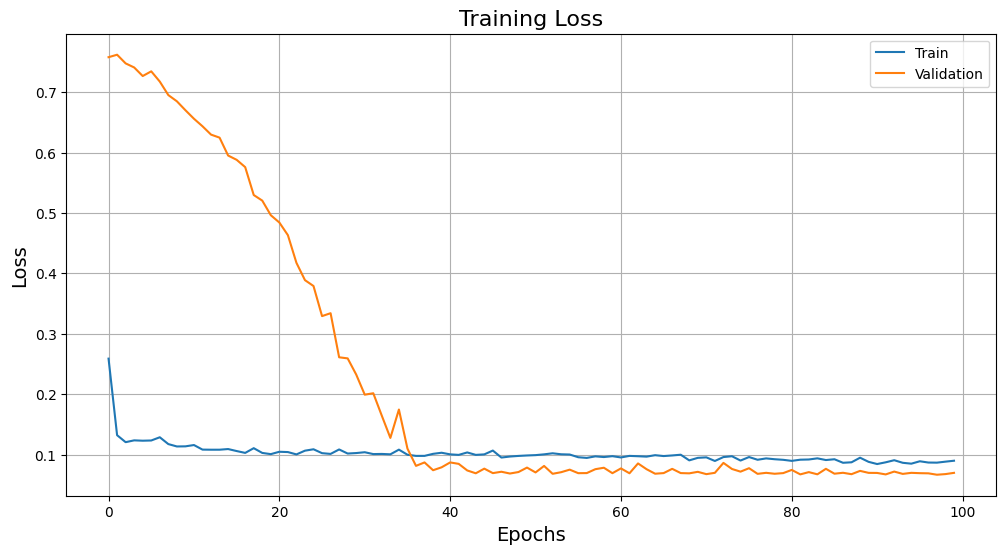

In [305]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [306]:
predict_test = model.predict(encode_input_data_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [307]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

In [308]:
print(predict_test_data)

[[20724.98  ]
 [20490.889 ]
 [16537.256 ]
 [16126.569 ]
 [11406.12  ]
 [10668.622 ]
 [ 8259.33  ]
 [ 7794.382 ]
 [ 8686.229 ]
 [ 8048.2104]
 [ 7579.1733]
 [ 7706.6694]
 [ 7652.094 ]
 [ 6791.725 ]
 [ 7448.758 ]
 [ 8033.9585]
 [ 7433.269 ]
 [ 9927.345 ]
 [14431.478 ]
 [18147.916 ]
 [20705.752 ]
 [20897.049 ]
 [21538.453 ]
 [20621.756 ]
 [17820.064 ]
 [20008.041 ]
 [19158.266 ]
 [17229.328 ]
 [10452.789 ]
 [ 8687.524 ]
 [ 8464.755 ]
 [ 8683.187 ]
 [ 7650.6533]
 [ 7444.3936]
 [ 7568.6567]
 [ 7383.7983]
 [ 7161.929 ]
 [ 5753.635 ]
 [ 5732.966 ]
 [ 5985.391 ]
 [ 9443.687 ]
 [17742.877 ]
 [18153.764 ]
 [21480.188 ]
 [23137.512 ]
 [21697.143 ]
 [19421.16  ]
 [16549.273 ]
 [16063.207 ]
 [19528.576 ]
 [15928.927 ]
 [14835.98  ]
 [11225.045 ]
 [ 8689.977 ]
 [ 7628.0405]
 [ 7817.9478]
 [ 7601.6323]
 [ 7693.711 ]
 [ 7737.91  ]
 [ 7476.7544]
 [ 7424.5396]
 [ 6784.421 ]
 [ 7556.4404]
 [ 8126.75  ]
 [10150.1045]
 [18880.89  ]
 [18919.025 ]
 [18854.725 ]
 [21500.223 ]
 [22132.576 ]
 [21854.338 ]
 [2241

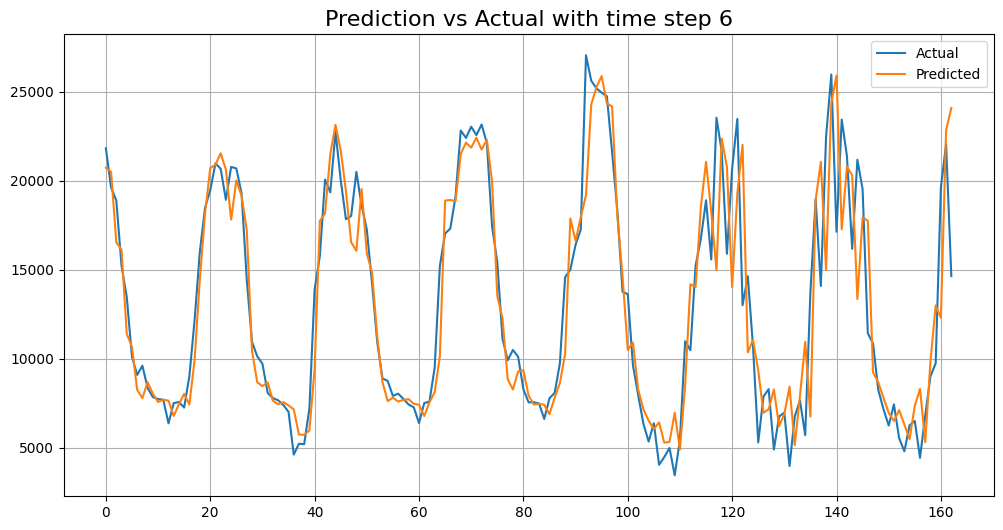

In [309]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.legend(['Actual', 'Predicted'])
plt.title(f'Prediction vs Actual with time step {time_step}')
plt.show()

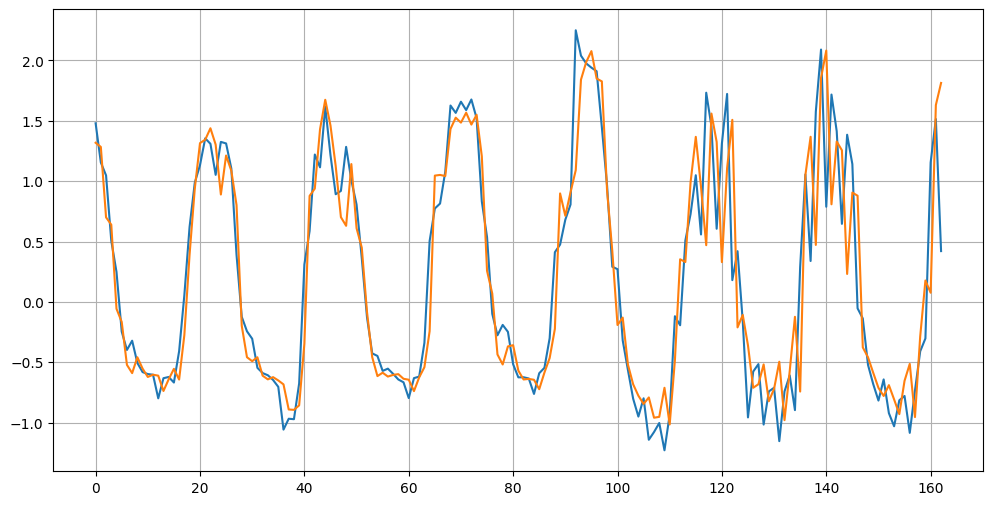

In [310]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

In [311]:
print(predict_test_data)

[[20724.98  ]
 [20490.889 ]
 [16537.256 ]
 [16126.569 ]
 [11406.12  ]
 [10668.622 ]
 [ 8259.33  ]
 [ 7794.382 ]
 [ 8686.229 ]
 [ 8048.2104]
 [ 7579.1733]
 [ 7706.6694]
 [ 7652.094 ]
 [ 6791.725 ]
 [ 7448.758 ]
 [ 8033.9585]
 [ 7433.269 ]
 [ 9927.345 ]
 [14431.478 ]
 [18147.916 ]
 [20705.752 ]
 [20897.049 ]
 [21538.453 ]
 [20621.756 ]
 [17820.064 ]
 [20008.041 ]
 [19158.266 ]
 [17229.328 ]
 [10452.789 ]
 [ 8687.524 ]
 [ 8464.755 ]
 [ 8683.187 ]
 [ 7650.6533]
 [ 7444.3936]
 [ 7568.6567]
 [ 7383.7983]
 [ 7161.929 ]
 [ 5753.635 ]
 [ 5732.966 ]
 [ 5985.391 ]
 [ 9443.687 ]
 [17742.877 ]
 [18153.764 ]
 [21480.188 ]
 [23137.512 ]
 [21697.143 ]
 [19421.16  ]
 [16549.273 ]
 [16063.207 ]
 [19528.576 ]
 [15928.927 ]
 [14835.98  ]
 [11225.045 ]
 [ 8689.977 ]
 [ 7628.0405]
 [ 7817.9478]
 [ 7601.6323]
 [ 7693.711 ]
 [ 7737.91  ]
 [ 7476.7544]
 [ 7424.5396]
 [ 6784.421 ]
 [ 7556.4404]
 [ 8126.75  ]
 [10150.1045]
 [18880.89  ]
 [18919.025 ]
 [18854.725 ]
 [21500.223 ]
 [22132.576 ]
 [21854.338 ]
 [2241

In [312]:
print(decode_output_test_data)

[[21818.]
 [19617.]
 [18893.]
 [15225.]
 [13474.]
 [10125.]
 [ 9095.]
 [ 9614.]
 [ 8365.]
 [ 7852.]
 [ 7742.]
 [ 7705.]
 [ 6379.]
 [ 7510.]
 [ 7578.]
 [ 7266.]
 [ 9024.]
 [12165.]
 [15993.]
 [18481.]
 [19469.]
 [20973.]
 [20665.]
 [18924.]
 [20773.]
 [20686.]
 [19284.]
 [14433.]
 [10957.]
 [10142.]
 [ 9724.]
 [ 8092.]
 [ 7797.]
 [ 7675.]
 [ 7411.]
 [ 7024.]
 [ 4624.]
 [ 5234.]
 [ 5208.]
 [ 7218.]
 [13893.]
 [15768.]
 [20065.]
 [19345.]
 [22742.]
 [20035.]
 [17836.]
 [18020.]
 [20494.]
 [18615.]
 [17256.]
 [14244.]
 [10929.]
 [ 8903.]
 [ 8760.]
 [ 7919.]
 [ 8046.]
 [ 7756.]
 [ 7438.]
 [ 7279.]
 [ 6393.]
 [ 7514.]
 [ 7600.]
 [ 9498.]
 [15210.]
 [17035.]
 [17313.]
 [19108.]
 [22815.]
 [22401.]
 [23029.]
 [22558.]
 [23153.]
 [22104.]
 [17432.]
 [15434.]
 [11121.]
 [ 9918.]
 [10501.]
 [10112.]
 [ 8291.]
 [ 7557.]
 [ 7563.]
 [ 7493.]
 [ 6627.]
 [ 7788.]
 [ 8094.]
 [ 9756.]
 [14581.]
 [15009.]
 [16406.]
 [17258.]
 [27038.]
 [25612.]
 [25178.]
 [24940.]
 [24741.]
 [21595.]
 [18327.]
 [13765.]


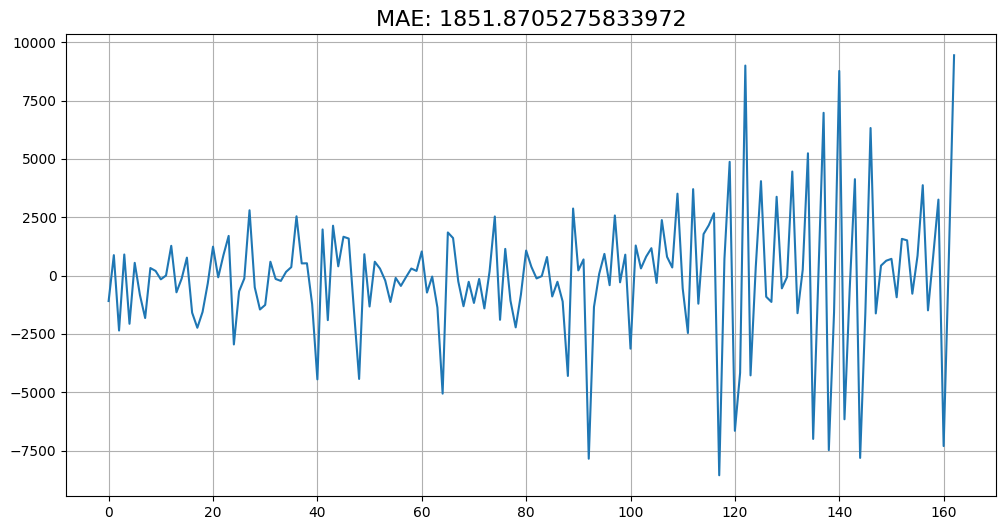

In [313]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()

In [314]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

1851.8705275833972
